In [2]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 8.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install yahooquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

from re import search
from yahooquery import Screener

In [5]:
def getRates(ticker_input ,period_input  ,interval_input ):
    print(ticker_input+" "+period_input+" "+interval_input )
    data = yf.download(tickers=ticker_input, period = period_input, interval = interval_input)
    return data["Close"]

In [6]:
def getPercChange(d):
    x=round(d.head(1),6).values
    y=round(d.tail(1),6).values
    perc_chg= np.round( (  (y-x) / abs(x)  ) *100  , 4)
    return perc_chg

In [7]:
def mail2me(pair_text,message_text):
    from email.message import EmailMessage
    import smtplib
    from pretty_html_table import build_table

    sender = "ozukun83@gmail.com"
    recipient = "ozukun83@gmail.com"
    message = "Crypto Info all"

    password = input("Type your password and press enter: ")
    
    email = EmailMessage()
    email["From"] = sender
    email["To"] = recipient
    email["Subject"] = "Crypto Rates Python!"+"  "+pair_text
    email.set_content(message_text)

    
    
    smtp = smtplib.SMTP_SSL("smtp.gmail.com")
    smtp.login(sender, password)
    smtp.sendmail(sender, recipient, email.as_string())
    smtp.quit()
    print("Mail succeed !!")

In [8]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=8)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [9]:
# moving average
def get_ma(prices, rate):
    return prices.rolling(rate).mean()



def get_bollinger_bands(prices, rate=7):
    sma = get_ma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down


def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    
    macd = pd.DataFrame(exp1 - exp2)
    macd.columns=["macd"]
    
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean())
    signal.columns=["signal"]
    
    hist = pd.DataFrame(macd['macd'] - signal['signal'])
    hist.columns=["hist"]
    
    frames =  [macd, signal, hist]
    
    df = pd.concat(frames, join = 'inner', axis = 1)
    df["result"]= np.select([df.macd > df.signal , df.macd < df.signal], ["Buy", "Sell"])
    return df




#HISTOGRAM = MACD LINE - SIGNAL LINE

#IF MACD LINE > SIGNAL LINE => BUY THE STOCK
#IF SIGNAL LINE > MACD LINE => SELL THE STOCK

#---------------------------------------------------------------


df_tmp_f = pd.DataFrame()
df_buy_signal=pd.DataFrame()
final_text=""
#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cpx in getCryptoPairs():
    Crypto_Pairs.append(cpx)


for cp in Crypto_Pairs:

    df_tmp_0 = pd.DataFrame(getRates(cp,  '1y',  '1d'))

    bollinger_up, bollinger_down = get_bollinger_bands(df_tmp_0)

    cp_macd=get_macd(getRates(cp,  '1y',  '1d'), 26, 12, 9)
    
    #display(cp_macd.iloc[-7:])

    df_tmp = pd.DataFrame(data=np.column_stack((df_tmp_0.values,bollinger_up,bollinger_down,cp_macd.macd,
                                                cp_macd.signal,cp_macd.result )),
                          columns=['Price','Bol_Up','Bol_Down',"macd","signal","result"])
    df_tmp.insert(0,'Crypto_Pair',cp)
    df_tmp.index=df_tmp_0.index


    #display( df_tmp.iloc[-7:] )
    
    x=round( df_tmp["Bol_Up"].iloc[-90:].mean() ,6 )
    #print("Bol_Up__Mean_for_last_7days   : " + str( x ) )
    
    
    y=round( df_tmp["Bol_Down"].iloc[-90:].mean() ,6 )
    #print("Bol_Down__Mean_for_last_7days : " + str( y ) )
    
    
    df_tmp_2 = pd.DataFrame(data=np.column_stack((cp,df_tmp.iloc[-1].Price,x,y )),
                          columns=["Crypto_Pair",'Price','Bol_Up_30','Bol_Down_30'])
    
    
    #display( df_tmp_2["Bol_Up_30"].values )
    
    x1="Bol_Up__Mean_for_last_7days   : " + str( x )
    y1="Bol_Down__Mean_for_last_7days : " + str( y )
    
    df_tmp_f = df_tmp_f.append(df_tmp.iloc[-7:])
    final_text=final_text+"\n"+cp+"\n"+str(x1)+"\n"+str(y1)
    r0=df_tmp.iloc[-1].Price
    r1= ( df_tmp.iloc[-1].Price+(df_tmp.iloc[-1].Price*0.05) ) 
    r2=float(df_tmp_2["Bol_Up_30"].values) 
    df_tmp_2["%change"]=((r2-r0)/ abs(r0) ) *100
    #print(r1)
    #print(r2)
    if r1<=r2:
        print("BUY_signal")
        df_buy_signal=df_buy_signal.append(df_tmp_2)
        #display(df_buy_signal)
        
#---------------------------------------------------------------------------
#display(df_buy_signal)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands",final_text)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands","")

BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
HEX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
HEX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed


In [10]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=10)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [11]:
def getRatesTable(*args):
    df_table = pd.DataFrame()
    for cp in args:
        df10yr=getRates(cp, '10y',  '1d')
        df5yr=getRates(cp,  '5y',  '1d')
        df3yr=getRates(cp,  '3y',  '1d')
        df1yr=getRates(cp,  '1y',  '1d')
        df3mo=getRates(cp,  '3mo',  '1h')
        df1mo=getRates(cp,  '1mo',  '1h')
        df1wk=getRates(cp,  '1wk',  '1h')
        df1dy=getRates(cp,  '1dy',  '1h')
        new_row = pd.Series(data={
                                   'Crypto_Pair':cp,
                                   '10yr_d_CHG%':getPercChange(df10yr)[0],
                                   '5yr_d_CHG%':getPercChange(df5yr)[0],
                                   '3yr_d_CHG%':getPercChange(df3yr)[0],
                                   '1yr_d_CHG%':getPercChange(df1yr)[0], 
                                   '3mo_h_CHG%':getPercChange(df3mo)[0], 
                                   '1mo_h_CHG%':getPercChange(df1mo)[0] ,
                                   '1wk_h_CHG%':getPercChange(df1wk)[0],
                                   '1dy_h_CHG%':getPercChange(df1dy)[0], 
                                 } 
                           )
        
        df_table = df_table.append(new_row, ignore_index=True)
    return df_table

#--------------------------------------------------------------------


#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cp in getCryptoPairs():
    Crypto_Pairs.append(cp)

dfx=getRatesTable(*Crypto_Pairs)

#dfx

BTC-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 complete

In [12]:
display(dfx)

,Crypto_Pair,10yr_d_CHG%,5yr_d_CHG%,3yr_d_CHG%,1yr_d_CHG%,3mo_h_CHG%,1mo_h_CHG%,1wk_h_CHG%,1dy_h_CHG%
0,BTC-USD,6299.8608,328.2336,326.3166,-30.6554,67.7918,46.0653,4.2262,3.0509
1,ETH-USD,491.7274,358.3683,1098.6170,-40.8830,41.7388,33.5276,4.3977,2.0325
2,BNB-USD,15687.1828,2511.1771,2187.7625,-24.9179,13.7852,13.4374,0.8564,0.5262
3,XRP-USD,135.4930,4.1140,173.2093,-32.3078,45.0045,39.1639,0.4243,1.2894
4,ADA-USD,1123.8386,150.9015,1081.0236,-61.9475,21.1629,26.1824,0.5429,0.8289
5,HEX-USD,45415.2047,45415.2047,18213.1765,-41.8351,266.4015,43.1112,-1.7595,5.7990
6,DOGE-USD,5861.3428,2672.0342,4186.2297,-43.5898,9.3987,28.6516,-13.3810,1.2738
7,STETH-USD,218.6828,218.6828,218.6828,-41.4365,43.2231,32.1568,4.2099,1.9571


In [13]:
def mail2me_v2(df,mail_subject,message_text):
    
    from email.mime.text import MIMEText
    from email.mime.application import MIMEApplication
    from email.mime.multipart import MIMEMultipart
    from smtplib import SMTP
    import smtplib
    import sys


    recipients = ['ozukun83@gmail.com'] 
    emaillist = [elem.strip().split(',') for elem in recipients]
    msg = MIMEMultipart()
    msg['Subject'] = mail_subject
    msg['From'] = 'ozukun83@gmail.com'

    password = input("Type your password and press enter: ")
    

    html = """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(df.to_html())

    part1 = MIMEText(html, 'html')
    msg.attach(part1)
    body = message_text
    body = MIMEText(body) # convert the body to a MIME compatible string
    msg.attach(body)

    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.ehlo()
    server.login("ozukun83@gmail.com",password)
    server.sendmail(msg['From'], emaillist , msg.as_string())
    print("Mail succeed !!")
    
#---------------------------------------------------------------------------
#mail2me_v2(dfx,"Crypto Rate changes","")

ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed


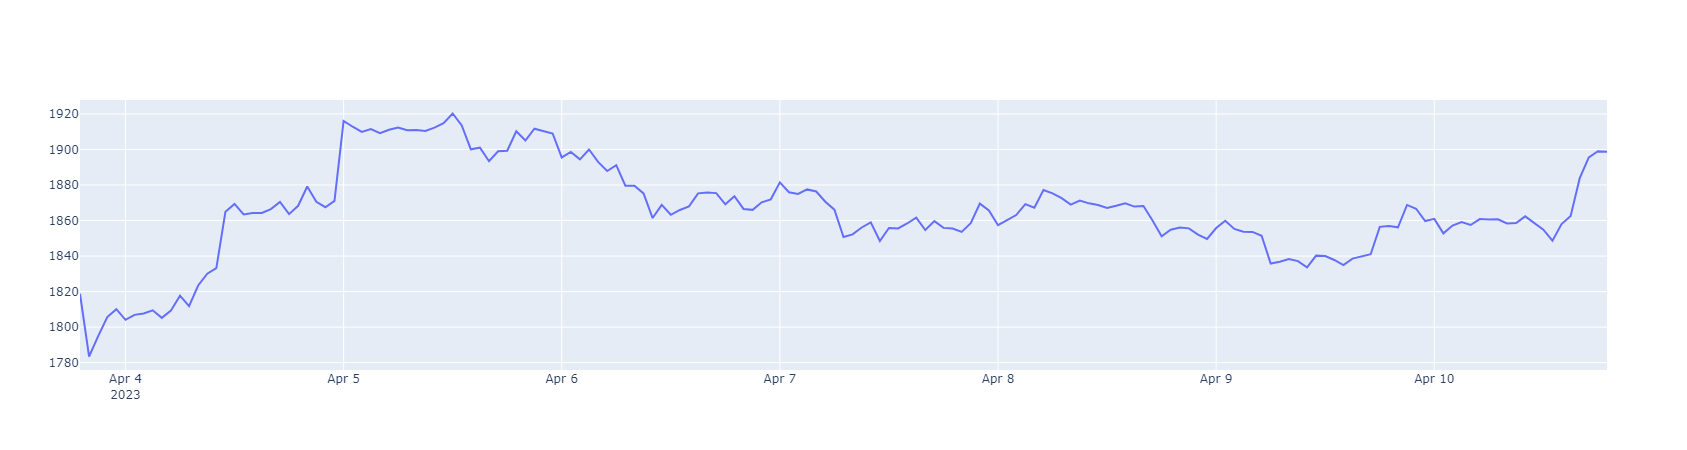

ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed


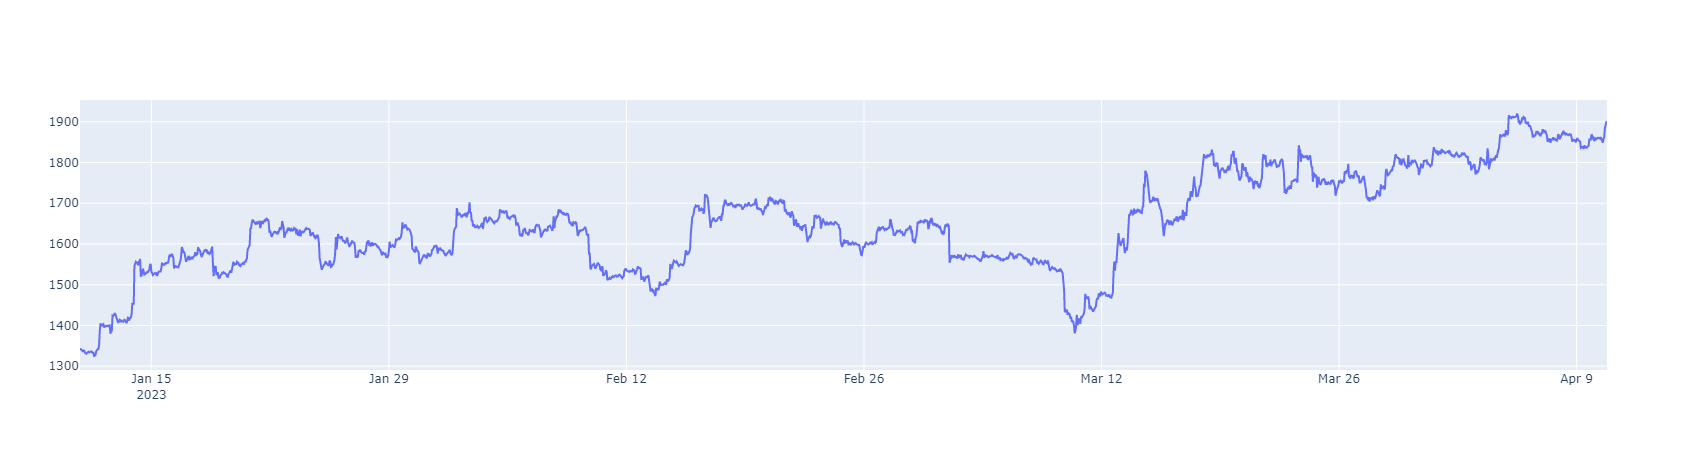

In [14]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def getLine(df_input):
    x = df_input.index
    y = df_input.values
    fig = go.Figure(data=go.Scatter(x = x, y = y))
    fig.show()
    
#------------------------------------------------

#( getLine(getRates('ETH-USD',  '1d',  '1h')) )
( getLine(getRates('ETH-USD',  '1wk',  '1h')) )
( getLine(getRates('ETH-USD',  '3mo',  '1h')) )
#( getLine(getRates('ETH-USD',  '3y',  '1d')) )

In [15]:
from datetime import timedelta
df_ALGO = pd.DataFrame(getRates('ALGO-USD',  '10y',  '1d'))
date=df_ALGO.index[-1]+ timedelta(days=1)

print(df_ALGO)

df_ALGO.loc[date, :] = [0]


print(df_ALGO.size)

df_ALGO['S1'] = df_ALGO['Close'].shift(1)
df_ALGO['SMA3'] = df_ALGO['Close'].rolling(3).mean().shift(1)
df_ALGO['SMA5'] = df_ALGO['Close'].rolling(5).mean().shift(1)
df_ALGO['SMA15'] = df_ALGO['Close'].rolling(15).mean().shift(1)
df_ALGO['SMA30'] = df_ALGO['Close'].rolling(30).mean().shift(1)

df_ALGO['S1'] = df_ALGO['S1'].fillna(0)
df_ALGO['SMA3'] = df_ALGO['SMA3'].fillna(0)
df_ALGO['SMA5'] = df_ALGO['SMA5'].fillna(0)
df_ALGO['SMA15'] = df_ALGO['SMA15'].fillna(0)
df_ALGO['SMA30'] = df_ALGO['SMA30'].fillna(0)



X = df_ALGO.iloc[:, 1:-1].values
y = df_ALGO.iloc[:, 0].values



df_ALGO

ALGO-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
               Close
Date                
2019-06-21  3.201412
2019-06-22  2.158967
2019-06-23  1.890702
2019-06-24  1.383728
2019-06-25  1.537290
...              ...
2023-04-06  0.217775
2023-04-07  0.219317
2023-04-08  0.216299
2023-04-09  0.216851
2023-04-10  0.219532

[1390 rows x 1 columns]
1391


,Close,S1,SMA3,SMA5,SMA15,SMA30
Date,,,,,,
2019-06-21,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-22,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000
2019-06-23,1.890702,2.158967,0.000000,0.000000,0.000000,0.000000
2019-06-24,1.383728,1.890702,2.417027,0.000000,0.000000,0.000000
2019-06-25,1.537290,1.383728,1.811132,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
2023-04-07,0.219317,0.217775,0.219596,0.217450,0.216154,0.212720
2023-04-08,0.216299,0.219317,0.219995,0.218494,0.216129,0.213286
2023-04-09,0.216851,0.216299,0.217797,0.218881,0.216601,0.214044


In [ ]:
# RNN Implementation FOR ALGO-USD pair

df_RNN = pd.DataFrame(columns=['Pair','p_units' ,'p_epoch' ,'p_batch_size' ,'prediction'])


df_alg = pd.DataFrame(getRates('ALGO-USD',  '10y',  '1d'))
date=df_alg.index[-1]+ timedelta(days=1)
df_alg.loc[date, :] = [0]


for i in range (1,91):
    a="Close_"+str(i)
    #print(a)
    df_alg[a]=df_alg['Close'].shift(i)

df_alg=df_alg.fillna(0)
display(df_alg)


X = df_alg.iloc[:, 1:].values
y = df_alg.iloc[:, 0].values

print(y.shape)
print(y)
y=y.reshape(-1,1)
print(y)

def calc_LTSM( *param_list ):
    for param in param_list:
        p_units=param[0] 
        p_epoch=param[1]  
        p_batch_size=param[2] 

        #from numpy.random import seed
        import tensorflow 
        #seed(0)
        tensorflow.random.set_seed(0)
        
        # Feature Scaling
        from sklearn.preprocessing import MinMaxScaler
        sc = MinMaxScaler(feature_range = (0, 1))
        X_scaled = sc.fit_transform(X)
        y_scaled = sc.fit_transform(y)

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.1, shuffle=False)
        # Reshaping
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

        # Importing the Keras libraries and packages
        from keras.models import Sequential
        from keras.layers import Dense
        from keras.layers import LSTM
        from keras.layers import Dropout
        regressor = Sequential()

        # Adding the first LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = p_units, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        regressor.add(Dropout(0.2))

        # Adding a second LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = p_units, return_sequences = True))
        regressor.add(Dropout(0.2))

        # Adding a fourth LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = p_units))
        regressor.add(Dropout(0.2))

        # Adding the output layer
        regressor.add(Dense(units = 1))

        # Compiling the RNN
        regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
        # Fitting the RNN to the Training set
        regressor.fit(X_train, y_train, epochs = p_epoch, batch_size = p_batch_size)

        lastElementIndex = len(X_test)-1
        # Removing the last element using slicing 
        X_pre = X_test[:lastElementIndex]
        y_pre = y_test[:lastElementIndex]
        X_pre = np.array(X_pre)
        X_pre = np.reshape(X_pre, (X_pre.shape[0], X_pre.shape[1], 1)) #   lenght of dataset,lenght of time_series , nof_input
        predicted_stock_price = regressor.predict(X_pre)
        #print("*****")
        #print(predicted_stock_price)

        index1 = len(X_test)-1
        index2 = len(X_test)
        X_final = X_test[index1:index2]
        y_final = y_test[index1:index2]
        X_final = np.array(X_final)
        X_final = np.reshape(X_final, (X_final.shape[0], X_final.shape[1], 1))

        print(y_final)
        print("Params: "+str(p_units)+" "+str(p_epoch)+" "+str(p_batch_size) )
        predicted_stock_price = regressor.predict(X_final)
        predicted_stock_price_f = sc.inverse_transform(predicted_stock_price)

        row1 = pd.Series(["ALGO-USD",p_units ,p_epoch ,p_batch_size,predicted_stock_price_f] ,index=df_RNN.columns )
        print(row1)
        df_RNN.loc[len(df_RNN.index)] = row1
        display(df_RNN)
        return predicted_stock_price_f





param_list=[]
for z in range (10,200,10):
    #print(z)
    param_list.append([z,10,150])
display(param_list)


for k in param_list:
    calc_LTSM(k)



display(df_RNN)
print(df_RNN.prediction.mean)

ALGO-USD 10y 1d
[*********************100%***********************]  1 of 1 completed


,Close,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Close_8,Close_9,...,Close_81,Close_82,Close_83,Close_84,Close_85,Close_86,Close_87,Close_88,Close_89,Close_90
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-21,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-22,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-23,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-24,1.383728,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-25,1.537290,1.383728,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-07,0.219317,0.217775,0.222892,0.218122,0.214364,0.214095,0.222180,0.225408,0.224584,0.234327,...,0.234289,0.240335,0.229522,0.221019,0.212526,0.210734,0.204071,0.200688,0.199550,0.194386
2023-04-08,0.216299,0.219317,0.217775,0.222892,0.218122,0.214364,0.214095,0.222180,0.225408,0.224584,...,0.229497,0.234289,0.240335,0.229522,0.221019,0.212526,0.210734,0.204071,0.200688,0.199550
2023-04-09,0.216851,0.216299,0.219317,0.217775,0.222892,0.218122,0.214364,0.214095,0.222180,0.225408,...,0.209594,0.229497,0.234289,0.240335,0.229522,0.221019,0.212526,0.210734,0.204071,0.200688


(1391,)
[3.20141196 2.15896702 1.89070201 ... 0.216851   0.21836534 0.        ]
[[3.20141196]
 [2.15896702]
 [1.89070201]
 ...
 [0.216851  ]
 [0.21836534]
 [0.        ]]


[[10, 10, 150],
 [20, 10, 150],
 [30, 10, 150],
 [40, 10, 150],
 [50, 10, 150],
 [60, 10, 150],
 [70, 10, 150],
 [80, 10, 150],
 [90, 10, 150],
 [100, 10, 150],
 [110, 10, 150],
 [120, 10, 150],
 [130, 10, 150],
 [140, 10, 150],
 [150, 10, 150],
 [160, 10, 150],
 [170, 10, 150],
 [180, 10, 150],
 [190, 10, 150],
 [200, 10, 150],
 [210, 10, 150],
 [220, 10, 150],
 [230, 10, 150],
 [240, 10, 150],
 [250, 10, 150],
 [260, 10, 150],
 [270, 10, 150],
 [280, 10, 150],
 [290, 10, 150],
 [300, 10, 150],
 [310, 10, 150],
 [320, 10, 150],
 [330, 10, 150],
 [340, 10, 150],
 [350, 10, 150],
 [360, 10, 150],
 [370, 10, 150],
 [380, 10, 150],
 [390, 10, 150],
 [400, 10, 150],
 [410, 10, 150],
 [420, 10, 150],
 [430, 10, 150],
 [440, 10, 150],
 [450, 10, 150],
 [460, 10, 150],
 [470, 10, 150],
 [480, 10, 150],
 [490, 10, 150]]

Epoch 1/10
9/9 [==============================] - 7s 120ms/step - loss: 0.0469
Epoch 2/10
9/9 [==============================] - 1s 117ms/step - loss: 0.0250
Epoch 3/10
9/9 [==============================] - 1s 118ms/step - loss: 0.0227
Epoch 4/10
9/9 [==============================] - 1s 118ms/step - loss: 0.0216
Epoch 5/10
9/9 [==============================] - 1s 117ms/step - loss: 0.0210
Epoch 6/10
9/9 [==============================] - 1s 116ms/step - loss: 0.0208
Epoch 7/10
9/9 [==============================] - 1s 117ms/step - loss: 0.0210
Epoch 8/10
9/9 [==============================] - 1s 114ms/step - loss: 0.0198
Epoch 9/10
9/9 [==============================] - 1s 118ms/step - loss: 0.0200
Epoch 10/10
9/9 [==============================] - 1s 115ms/step - loss: 0.0201
[[0.]]
Params: 10 10 150
Pair                 ALGO-USD
p_units                    10
p_epoch                    10
p_batch_size              150
prediction      [[0.4256876]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]


Epoch 1/10
9/9 [==============================] - 8s 236ms/step - loss: 0.0338
Epoch 2/10
9/9 [==============================] - 2s 236ms/step - loss: 0.0220
Epoch 3/10
9/9 [==============================] - 2s 251ms/step - loss: 0.0211
Epoch 4/10
9/9 [==============================] - 2s 247ms/step - loss: 0.0197
Epoch 5/10
9/9 [==============================] - 2s 237ms/step - loss: 0.0189
Epoch 6/10
9/9 [==============================] - 2s 243ms/step - loss: 0.0195
Epoch 7/10
9/9 [==============================] - 2s 246ms/step - loss: 0.0186
Epoch 8/10
9/9 [==============================] - 2s 247ms/step - loss: 0.0190
Epoch 9/10
9/9 [==============================] - 2s 232ms/step - loss: 0.0191
Epoch 10/10
9/9 [==============================] - 2s 234ms/step - loss: 0.0182
[[0.]]
Params: 20 10 150
Pair                  ALGO-USD
p_units                     20
p_epoch                     10
p_batch_size               150
prediction      [[0.43825185]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]


Epoch 1/10
9/9 [==============================] - 9s 269ms/step - loss: 0.0396
Epoch 2/10
9/9 [==============================] - 2s 267ms/step - loss: 0.0219
Epoch 3/10
9/9 [==============================] - 3s 281ms/step - loss: 0.0218
Epoch 4/10
9/9 [==============================] - 2s 268ms/step - loss: 0.0195
Epoch 5/10
9/9 [==============================] - 2s 268ms/step - loss: 0.0194
Epoch 6/10
9/9 [==============================] - 3s 279ms/step - loss: 0.0194
Epoch 7/10
9/9 [==============================] - 2s 271ms/step - loss: 0.0190
Epoch 8/10
9/9 [==============================] - 2s 274ms/step - loss: 0.0187
Epoch 9/10
9/9 [==============================] - 2s 268ms/step - loss: 0.0186
Epoch 10/10
9/9 [==============================] - 3s 341ms/step - loss: 0.0180
[[0.]]
Params: 30 10 150
Pair                 ALGO-USD
p_units                    30
p_epoch                    10
p_batch_size              150
prediction      [[0.4174666]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]


Epoch 1/10
9/9 [==============================] - 9s 296ms/step - loss: 0.0389
Epoch 2/10
9/9 [==============================] - 3s 295ms/step - loss: 0.0203
Epoch 3/10
9/9 [==============================] - 3s 303ms/step - loss: 0.0208
Epoch 4/10
9/9 [==============================] - 3s 297ms/step - loss: 0.0197
Epoch 5/10
9/9 [==============================] - 3s 292ms/step - loss: 0.0191
Epoch 6/10
9/9 [==============================] - 3s 296ms/step - loss: 0.0189
Epoch 7/10
9/9 [==============================] - 3s 306ms/step - loss: 0.0184
Epoch 8/10
9/9 [==============================] - 3s 364ms/step - loss: 0.0181
Epoch 9/10
9/9 [==============================] - 3s 293ms/step - loss: 0.0178
Epoch 10/10
9/9 [==============================] - 3s 291ms/step - loss: 0.0161
[[0.]]
Params: 40 10 150
Pair                  ALGO-USD
p_units                     40
p_epoch                     10
p_batch_size               150
prediction      [[0.33006465]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]


Epoch 1/10
9/9 [==============================] - 10s 351ms/step - loss: 0.0398
Epoch 2/10
9/9 [==============================] - 3s 330ms/step - loss: 0.0205
Epoch 3/10
9/9 [==============================] - 3s 329ms/step - loss: 0.0203
Epoch 4/10
9/9 [==============================] - 3s 323ms/step - loss: 0.0192
Epoch 5/10
9/9 [==============================] - 4s 424ms/step - loss: 0.0189
Epoch 6/10
9/9 [==============================] - 3s 326ms/step - loss: 0.0184
Epoch 7/10
9/9 [==============================] - 3s 323ms/step - loss: 0.0179
Epoch 8/10
9/9 [==============================] - 3s 335ms/step - loss: 0.0167
Epoch 9/10
9/9 [==============================] - 3s 327ms/step - loss: 0.0121
Epoch 10/10
9/9 [==============================] - 3s 324ms/step - loss: 0.0100
[[0.]]
Params: 50 10 150
Pair                  ALGO-USD
p_units                     50
p_epoch                     10
p_batch_size               150
prediction      [[0.45603904]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]


Epoch 1/10
9/9 [==============================] - 10s 362ms/step - loss: 0.0333
Epoch 2/10
9/9 [==============================] - 3s 360ms/step - loss: 0.0209
Epoch 3/10
9/9 [==============================] - 4s 388ms/step - loss: 0.0198
Epoch 4/10
9/9 [==============================] - 3s 359ms/step - loss: 0.0189
Epoch 5/10
9/9 [==============================] - 3s 358ms/step - loss: 0.0192
Epoch 6/10
9/9 [==============================] - 3s 367ms/step - loss: 0.0187
Epoch 7/10
9/9 [==============================] - 3s 367ms/step - loss: 0.0182
Epoch 8/10
9/9 [==============================] - 3s 365ms/step - loss: 0.0172
Epoch 9/10
9/9 [==============================] - 3s 377ms/step - loss: 0.0141
Epoch 10/10
9/9 [==============================] - 3s 367ms/step - loss: 0.0118
[[0.]]
Params: 60 10 150
Pair                ALGO-USD
p_units                   60
p_epoch                   10
p_batch_size             150
prediction      [[0.320823]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]


Epoch 1/10
9/9 [==============================] - 10s 390ms/step - loss: 0.0326
Epoch 2/10
9/9 [==============================] - 4s 389ms/step - loss: 0.0209
Epoch 3/10
9/9 [==============================] - 4s 395ms/step - loss: 0.0197
Epoch 4/10
9/9 [==============================] - 4s 392ms/step - loss: 0.0192
Epoch 5/10
9/9 [==============================] - 4s 392ms/step - loss: 0.0189
Epoch 6/10
9/9 [==============================] - 4s 399ms/step - loss: 0.0192
Epoch 7/10
9/9 [==============================] - 4s 390ms/step - loss: 0.0184
Epoch 8/10
9/9 [==============================] - 4s 503ms/step - loss: 0.0163
Epoch 9/10
9/9 [==============================] - 4s 393ms/step - loss: 0.0127
Epoch 10/10
9/9 [==============================] - 4s 390ms/step - loss: 0.0102
[[0.]]
Params: 70 10 150
Pair                  ALGO-USD
p_units                     70
p_epoch                     10
p_batch_size               150
prediction      [[0.36329794]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]


Epoch 1/10
9/9 [==============================] - 10s 413ms/step - loss: 0.0305
Epoch 2/10
9/9 [==============================] - 4s 424ms/step - loss: 0.0212
Epoch 3/10
9/9 [==============================] - 4s 413ms/step - loss: 0.0196
Epoch 4/10
9/9 [==============================] - 5s 510ms/step - loss: 0.0190
Epoch 5/10
9/9 [==============================] - 4s 422ms/step - loss: 0.0187
Epoch 6/10
9/9 [==============================] - 4s 411ms/step - loss: 0.0182
Epoch 7/10
9/9 [==============================] - 4s 416ms/step - loss: 0.0166
Epoch 8/10
9/9 [==============================] - 4s 421ms/step - loss: 0.0124
Epoch 9/10
9/9 [==============================] - 4s 419ms/step - loss: 0.0092
Epoch 10/10
9/9 [==============================] - 4s 429ms/step - loss: 0.0068
[[0.]]
Params: 80 10 150
Pair                  ALGO-USD
p_units                     80
p_epoch                     10
p_batch_size               150
prediction      [[0.18425272]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]


Epoch 1/10
9/9 [==============================] - 11s 494ms/step - loss: 0.0325
Epoch 2/10
9/9 [==============================] - 4s 485ms/step - loss: 0.0216
Epoch 3/10
9/9 [==============================] - 5s 502ms/step - loss: 0.0198
Epoch 4/10
9/9 [==============================] - 4s 494ms/step - loss: 0.0192
Epoch 5/10
9/9 [==============================] - 5s 496ms/step - loss: 0.0185
Epoch 6/10
9/9 [==============================] - 5s 606ms/step - loss: 0.0183
Epoch 7/10
9/9 [==============================] - 4s 492ms/step - loss: 0.0171
Epoch 8/10
9/9 [==============================] - 5s 508ms/step - loss: 0.0133
Epoch 9/10
9/9 [==============================] - 4s 494ms/step - loss: 0.0102
Epoch 10/10
9/9 [==============================] - 5s 505ms/step - loss: 0.0124
[[0.]]
Params: 90 10 150
Pair                  ALGO-USD
p_units                     90
p_epoch                     10
p_batch_size               150
prediction      [[0.31986347]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]
8,ALGO-USD,90,10,150,[[0.31986347]]


Epoch 1/10
9/9 [==============================] - 12s 628ms/step - loss: 0.0317
Epoch 2/10
9/9 [==============================] - 5s 537ms/step - loss: 0.0219
Epoch 3/10
9/9 [==============================] - 5s 542ms/step - loss: 0.0189
Epoch 4/10
9/9 [==============================] - 5s 527ms/step - loss: 0.0189
Epoch 5/10
9/9 [==============================] - 5s 538ms/step - loss: 0.0180
Epoch 6/10
9/9 [==============================] - 5s 532ms/step - loss: 0.0179
Epoch 7/10
9/9 [==============================] - 6s 616ms/step - loss: 0.0154
Epoch 8/10
9/9 [==============================] - 5s 527ms/step - loss: 0.0134
Epoch 9/10
9/9 [==============================] - 5s 525ms/step - loss: 0.0089
Epoch 10/10
9/9 [==============================] - 5s 526ms/step - loss: 0.0093
[[0.]]
Params: 100 10 150
Pair                 ALGO-USD
p_units                   100
p_epoch                    10
p_batch_size              150
prediction      [[0.2096222]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]
8,ALGO-USD,90,10,150,[[0.31986347]]
9,ALGO-USD,100,10,150,[[0.2096222]]


Epoch 1/10
9/9 [==============================] - 12s 579ms/step - loss: 0.0305
Epoch 2/10
9/9 [==============================] - 6s 644ms/step - loss: 0.0216
Epoch 3/10
9/9 [==============================] - 5s 574ms/step - loss: 0.0193
Epoch 4/10
9/9 [==============================] - 5s 576ms/step - loss: 0.0188
Epoch 5/10
9/9 [==============================] - 5s 585ms/step - loss: 0.0184
Epoch 6/10
9/9 [==============================] - 5s 587ms/step - loss: 0.0181
Epoch 7/10
9/9 [==============================] - 6s 641ms/step - loss: 0.0144
Epoch 8/10
9/9 [==============================] - 5s 586ms/step - loss: 0.0160
Epoch 9/10
9/9 [==============================] - 5s 587ms/step - loss: 0.0108
Epoch 10/10
9/9 [==============================] - 5s 590ms/step - loss: 0.0091
[[0.]]
Params: 110 10 150
Pair                  ALGO-USD
p_units                    110
p_epoch                     10
p_batch_size               150
prediction      [[0.40682414]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]
8,ALGO-USD,90,10,150,[[0.31986347]]
9,ALGO-USD,100,10,150,[[0.2096222]]


Epoch 1/10
9/9 [==============================] - 12s 617ms/step - loss: 0.0335
Epoch 2/10
9/9 [==============================] - 6s 643ms/step - loss: 0.0231
Epoch 3/10
9/9 [==============================] - 6s 615ms/step - loss: 0.0201
Epoch 4/10
9/9 [==============================] - 6s 630ms/step - loss: 0.0192
Epoch 5/10
9/9 [==============================] - 6s 613ms/step - loss: 0.0189
Epoch 6/10
9/9 [==============================] - 6s 613ms/step - loss: 0.0186
Epoch 7/10
9/9 [==============================] - 6s 699ms/step - loss: 0.0181
Epoch 8/10
9/9 [==============================] - 6s 610ms/step - loss: 0.0179
Epoch 9/10
9/9 [==============================] - 5s 594ms/step - loss: 0.0141
Epoch 10/10
9/9 [==============================] - 6s 618ms/step - loss: 0.0116
[[0.]]
Params: 120 10 150
Pair                 ALGO-USD
p_units                   120
p_epoch                    10
p_batch_size              150
prediction      [[0.2969747]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]
8,ALGO-USD,90,10,150,[[0.31986347]]
9,ALGO-USD,100,10,150,[[0.2096222]]


Epoch 1/10
9/9 [==============================] - 14s 800ms/step - loss: 0.0305
Epoch 2/10
9/9 [==============================] - 7s 718ms/step - loss: 0.0218
Epoch 3/10
9/9 [==============================] - 7s 722ms/step - loss: 0.0192
Epoch 4/10
9/9 [==============================] - 6s 703ms/step - loss: 0.0187
Epoch 5/10
9/9 [==============================] - 7s 793ms/step - loss: 0.0180
Epoch 6/10
9/9 [==============================] - 7s 743ms/step - loss: 0.0180
Epoch 7/10
9/9 [==============================] - 7s 717ms/step - loss: 0.0151
Epoch 8/10
9/9 [==============================] - 7s 723ms/step - loss: 0.0109
Epoch 9/10
9/9 [==============================] - 6s 718ms/step - loss: 0.0100
Epoch 10/10
9/9 [==============================] - 7s 808ms/step - loss: 0.0089
[[0.]]
Params: 130 10 150
Pair                  ALGO-USD
p_units                    130
p_epoch                     10
p_batch_size               150
prediction      [[0.34120974]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]
8,ALGO-USD,90,10,150,[[0.31986347]]
9,ALGO-USD,100,10,150,[[0.2096222]]


Epoch 1/10
9/9 [==============================] - 14s 761ms/step - loss: 0.0369
Epoch 2/10
9/9 [==============================] - 7s 769ms/step - loss: 0.0241
Epoch 3/10
9/9 [==============================] - 8s 882ms/step - loss: 0.0194
Epoch 4/10
9/9 [==============================] - 7s 744ms/step - loss: 0.0191
Epoch 5/10
9/9 [==============================] - 7s 772ms/step - loss: 0.0185
Epoch 6/10
9/9 [==============================] - 7s 771ms/step - loss: 0.0182
Epoch 7/10
9/9 [==============================] - 7s 736ms/step - loss: 0.0165
Epoch 8/10
9/9 [==============================] - 8s 854ms/step - loss: 0.0144
Epoch 9/10
9/9 [==============================] - 7s 735ms/step - loss: 0.0121
Epoch 10/10
9/9 [==============================] - 7s 739ms/step - loss: 0.0114
[[0.]]
Params: 140 10 150
Pair                  ALGO-USD
p_units                    140
p_epoch                     10
p_batch_size               150
prediction      [[0.47553602]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]
8,ALGO-USD,90,10,150,[[0.31986347]]
9,ALGO-USD,100,10,150,[[0.2096222]]


Epoch 1/10
9/9 [==============================] - 15s 902ms/step - loss: 0.0359
Epoch 2/10
9/9 [==============================] - 7s 801ms/step - loss: 0.0235
Epoch 3/10
9/9 [==============================] - 7s 802ms/step - loss: 0.0192
Epoch 4/10
9/9 [==============================] - 7s 780ms/step - loss: 0.0191
Epoch 5/10
9/9 [==============================] - 8s 889ms/step - loss: 0.0187
Epoch 6/10
9/9 [==============================] - 7s 778ms/step - loss: 0.0186
Epoch 7/10
9/9 [==============================] - 7s 782ms/step - loss: 0.0168
Epoch 8/10
9/9 [==============================] - 7s 786ms/step - loss: 0.0164
Epoch 9/10
9/9 [==============================] - 8s 885ms/step - loss: 0.0140
Epoch 10/10
9/9 [==============================] - 8s 844ms/step - loss: 0.0115
[[0.]]
Params: 150 10 150
Pair                  ALGO-USD
p_units                    150
p_epoch                     10
p_batch_size               150
prediction      [[0.22364734]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]
8,ALGO-USD,90,10,150,[[0.31986347]]
9,ALGO-USD,100,10,150,[[0.2096222]]


Epoch 1/10
9/9 [==============================] - 14s 876ms/step - loss: 0.0315
Epoch 2/10
9/9 [==============================] - 8s 945ms/step - loss: 0.0217
Epoch 3/10
9/9 [==============================] - 8s 861ms/step - loss: 0.0200
Epoch 4/10
9/9 [==============================] - 8s 849ms/step - loss: 0.0193
Epoch 5/10
9/9 [==============================] - 8s 835ms/step - loss: 0.0188
Epoch 6/10
9/9 [==============================] - 9s 959ms/step - loss: 0.0192
Epoch 7/10
9/9 [==============================] - 8s 849ms/step - loss: 0.0172
Epoch 8/10
9/9 [==============================] - 8s 858ms/step - loss: 0.0182
Epoch 9/10
9/9 [==============================] - 8s 845ms/step - loss: 0.0191
Epoch 10/10
9/9 [==============================] - 9s 954ms/step - loss: 0.0157
[[0.]]
Params: 160 10 150
Pair                 ALGO-USD
p_units                   160
p_epoch                    10
p_batch_size              150
prediction      [[0.2510896]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]
8,ALGO-USD,90,10,150,[[0.31986347]]
9,ALGO-USD,100,10,150,[[0.2096222]]


Epoch 1/10
9/9 [==============================] - 15s 968ms/step - loss: 0.0282
Epoch 2/10
9/9 [==============================] - 10s 1s/step - loss: 0.0217
Epoch 3/10
9/9 [==============================] - 9s 940ms/step - loss: 0.0211
Epoch 4/10
9/9 [==============================] - 9s 954ms/step - loss: 0.0194
Epoch 5/10
9/9 [==============================] - 9s 941ms/step - loss: 0.0191
Epoch 6/10
9/9 [==============================] - 9s 1s/step - loss: 0.0186
Epoch 7/10
9/9 [==============================] - 9s 945ms/step - loss: 0.0152
Epoch 8/10
9/9 [==============================] - 8s 924ms/step - loss: 0.0136
Epoch 9/10
9/9 [==============================] - 9s 949ms/step - loss: 0.0128
Epoch 10/10
9/9 [==============================] - 10s 983ms/step - loss: 0.0128
[[0.]]
Params: 170 10 150
Pair                  ALGO-USD
p_units                    170
p_epoch                     10
p_batch_size               150
prediction      [[0.09605243]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]
8,ALGO-USD,90,10,150,[[0.31986347]]
9,ALGO-USD,100,10,150,[[0.2096222]]


Epoch 1/10
9/9 [==============================] - 16s 1s/step - loss: 0.0372
Epoch 2/10
9/9 [==============================] - 10s 1s/step - loss: 0.0231
Epoch 3/10
9/9 [==============================] - 9s 1s/step - loss: 0.0198
Epoch 4/10
9/9 [==============================] - 9s 973ms/step - loss: 0.0193
Epoch 5/10
9/9 [==============================] - 10s 1s/step - loss: 0.0190
Epoch 6/10
9/9 [==============================] - 9s 996ms/step - loss: 0.0190
Epoch 7/10
9/9 [==============================] - 9s 1s/step - loss: 0.0182
Epoch 8/10
9/9 [==============================] - 9s 1s/step - loss: 0.0175
Epoch 9/10
9/9 [==============================] - 10s 1s/step - loss: 0.0162
Epoch 10/10
9/9 [==============================] - 9s 1s/step - loss: 0.0200
[[0.]]
Params: 180 10 150
Pair                 ALGO-USD
p_units                   180
p_epoch                    10
p_batch_size              150
prediction      [[0.6933077]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]
8,ALGO-USD,90,10,150,[[0.31986347]]
9,ALGO-USD,100,10,150,[[0.2096222]]


Epoch 1/10
9/9 [==============================] - 17s 1s/step - loss: 0.0285
Epoch 2/10
9/9 [==============================] - 10s 1s/step - loss: 0.0217
Epoch 3/10
9/9 [==============================] - 10s 1s/step - loss: 0.0206
Epoch 4/10
9/9 [==============================] - 11s 1s/step - loss: 0.0193
Epoch 5/10
9/9 [==============================] - 10s 1s/step - loss: 0.0186
Epoch 6/10
9/9 [==============================] - 10s 1s/step - loss: 0.0171
Epoch 7/10
9/9 [==============================] - 11s 1s/step - loss: 0.0276
Epoch 8/10
9/9 [==============================] - 10s 1s/step - loss: 0.0206
Epoch 9/10
9/9 [==============================] - 10s 1s/step - loss: 0.0193
Epoch 10/10
9/9 [==============================] - 11s 1s/step - loss: 0.0193
[[0.]]
Params: 190 10 150
Pair                  ALGO-USD
p_units                    190
p_epoch                     10
p_batch_size               150
prediction      [[0.47046155]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]
8,ALGO-USD,90,10,150,[[0.31986347]]
9,ALGO-USD,100,10,150,[[0.2096222]]


Epoch 1/10
9/9 [==============================] - 17s 1s/step - loss: 0.0357
Epoch 2/10
9/9 [==============================] - 11s 1s/step - loss: 0.0228
Epoch 3/10
9/9 [==============================] - 10s 1s/step - loss: 0.0205
Epoch 4/10
9/9 [==============================] - 10s 1s/step - loss: 0.0195
Epoch 5/10
9/9 [==============================] - 11s 1s/step - loss: 0.0191
Epoch 6/10
9/9 [==============================] - 10s 1s/step - loss: 0.0188
Epoch 7/10
9/9 [==============================] - 10s 1s/step - loss: 0.0177
Epoch 8/10
9/9 [==============================] - 11s 1s/step - loss: 0.0173
Epoch 9/10
9/9 [==============================] - 11s 1s/step - loss: 0.0157
Epoch 10/10
9/9 [==============================] - 10s 1s/step - loss: 0.0102
[[0.]]
Params: 200 10 150
Pair                  ALGO-USD
p_units                    200
p_epoch                     10
p_batch_size               150
prediction      [[0.12812923]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]
8,ALGO-USD,90,10,150,[[0.31986347]]
9,ALGO-USD,100,10,150,[[0.2096222]]


Epoch 1/10
9/9 [==============================] - 18s 1s/step - loss: 0.0300
Epoch 2/10
9/9 [==============================] - 11s 1s/step - loss: 0.0211
Epoch 3/10
9/9 [==============================] - 12s 1s/step - loss: 0.0205
Epoch 4/10
9/9 [==============================] - 11s 1s/step - loss: 0.0190
Epoch 5/10
9/9 [==============================] - 12s 1s/step - loss: 0.0187
Epoch 6/10
9/9 [==============================] - 11s 1s/step - loss: 0.0167
Epoch 7/10
9/9 [==============================] - 11s 1s/step - loss: 0.0276
Epoch 8/10
9/9 [==============================] - 12s 1s/step - loss: 0.0202
Epoch 9/10
9/9 [==============================] - 11s 1s/step - loss: 0.0203
Epoch 10/10
9/9 [==============================] - 11s 1s/step - loss: 0.0201
[[0.]]
Params: 210 10 150
Pair                  ALGO-USD
p_units                    210
p_epoch                     10
p_batch_size               150
prediction      [[0.52754277]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]
8,ALGO-USD,90,10,150,[[0.31986347]]
9,ALGO-USD,100,10,150,[[0.2096222]]


Epoch 1/10
9/9 [==============================] - 19s 1s/step - loss: 0.0379
Epoch 2/10
9/9 [==============================] - 13s 1s/step - loss: 0.0234
Epoch 3/10
9/9 [==============================] - 12s 1s/step - loss: 0.0218
Epoch 4/10
9/9 [==============================] - 12s 1s/step - loss: 0.0198
Epoch 5/10
9/9 [==============================] - 13s 1s/step - loss: 0.0193
Epoch 6/10
9/9 [==============================] - 12s 1s/step - loss: 0.0192
Epoch 7/10
9/9 [==============================] - 12s 1s/step - loss: 0.0183
Epoch 8/10
9/9 [==============================] - 13s 1s/step - loss: 0.0168
Epoch 9/10
9/9 [==============================] - 13s 1s/step - loss: 0.0172
Epoch 10/10
9/9 [==============================] - 13s 1s/step - loss: 0.0155
[[0.]]
Params: 220 10 150
Pair                  ALGO-USD
p_units                    220
p_epoch                     10
p_batch_size               150
prediction      [[0.23149756]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]
8,ALGO-USD,90,10,150,[[0.31986347]]
9,ALGO-USD,100,10,150,[[0.2096222]]


Epoch 1/10
9/9 [==============================] - 20s 2s/step - loss: 0.0420
Epoch 2/10
9/9 [==============================] - 14s 1s/step - loss: 0.0237
Epoch 3/10
9/9 [==============================] - 13s 1s/step - loss: 0.0213
Epoch 4/10
9/9 [==============================] - 14s 2s/step - loss: 0.0199
Epoch 5/10
9/9 [==============================] - 13s 1s/step - loss: 0.0192
Epoch 6/10
9/9 [==============================] - 14s 2s/step - loss: 0.0189
Epoch 7/10
9/9 [==============================] - 13s 1s/step - loss: 0.0187
Epoch 8/10
9/9 [==============================] - 14s 2s/step - loss: 0.0183
Epoch 9/10
9/9 [==============================] - 13s 1s/step - loss: 0.0142
Epoch 10/10
9/9 [==============================] - 13s 1s/step - loss: 0.0174
[[0.]]
Params: 230 10 150
Pair                  ALGO-USD
p_units                    230
p_epoch                     10
p_batch_size               150
prediction      [[0.39530617]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]
8,ALGO-USD,90,10,150,[[0.31986347]]
9,ALGO-USD,100,10,150,[[0.2096222]]


Epoch 1/10
9/9 [==============================] - 20s 1s/step - loss: 0.0407
Epoch 2/10
9/9 [==============================] - 14s 2s/step - loss: 0.0237
Epoch 3/10
9/9 [==============================] - 14s 2s/step - loss: 0.0218
Epoch 4/10
9/9 [==============================] - 14s 1s/step - loss: 0.0201
Epoch 5/10
9/9 [==============================] - 14s 2s/step - loss: 0.0194
Epoch 6/10
9/9 [==============================] - 13s 1s/step - loss: 0.0191
Epoch 7/10
9/9 [==============================] - 14s 2s/step - loss: 0.0183
Epoch 8/10
9/9 [==============================] - 13s 1s/step - loss: 0.0159
Epoch 9/10
9/9 [==============================] - 14s 2s/step - loss: 0.0159
Epoch 10/10
9/9 [==============================] - 13s 1s/step - loss: 0.0115
[[0.]]
Params: 240 10 150
Pair                 ALGO-USD
p_units                   240
p_epoch                    10
p_batch_size              150
prediction      [[0.2795953]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]
8,ALGO-USD,90,10,150,[[0.31986347]]
9,ALGO-USD,100,10,150,[[0.2096222]]


Epoch 1/10
9/9 [==============================] - 22s 2s/step - loss: 0.0424
Epoch 2/10
9/9 [==============================] - 14s 2s/step - loss: 0.0236
Epoch 3/10
9/9 [==============================] - 15s 2s/step - loss: 0.0216
Epoch 4/10
9/9 [==============================] - 15s 2s/step - loss: 0.0200
Epoch 5/10
9/9 [==============================] - 15s 2s/step - loss: 0.0196
Epoch 6/10
9/9 [==============================] - 15s 2s/step - loss: 0.0190
Epoch 7/10
9/9 [==============================] - 15s 2s/step - loss: 0.0185
Epoch 8/10
9/9 [==============================] - 15s 2s/step - loss: 0.0175
Epoch 9/10
9/9 [==============================] - 16s 2s/step - loss: 0.0218
Epoch 10/10
9/9 [==============================] - 15s 2s/step - loss: 0.0157
[[0.]]
Params: 250 10 150
Pair                  ALGO-USD
p_units                    250
p_epoch                     10
p_batch_size               150
prediction      [[0.32948902]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.4256876]]
1,ALGO-USD,20,10,150,[[0.43825185]]
2,ALGO-USD,30,10,150,[[0.4174666]]
3,ALGO-USD,40,10,150,[[0.33006465]]
4,ALGO-USD,50,10,150,[[0.45603904]]
5,ALGO-USD,60,10,150,[[0.320823]]
6,ALGO-USD,70,10,150,[[0.36329794]]
7,ALGO-USD,80,10,150,[[0.18425272]]
8,ALGO-USD,90,10,150,[[0.31986347]]
9,ALGO-USD,100,10,150,[[0.2096222]]


Epoch 1/10
9/9 [==============================] - 22s 2s/step - loss: 0.0549
Epoch 2/10
9/9 [==============================] - 15s 2s/step - loss: 0.0254
Epoch 3/10
9/9 [==============================] - 16s 2s/step - loss: 0.0227
Epoch 4/10
9/9 [==============================] - 15s 2s/step - loss: 0.0204
Epoch 5/10
5/9 [===============>..............] - ETA: 7s - loss: 0.0206 

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,100,10,150,[[0.20963451]]
1,ALGO-USD,150,10,150,[[0.2236595]]
2,ALGO-USD,200,10,150,[[0.12813637]]


,Index_val,Prediction
0,0.0,0.209635
1,1.0,0.223660
2,2.0,0.128136


,Pair,p_units,p_epoch,p_batch_size,prediction,Index_val,Prediction
0,ALGO-USD,100,10,150,[[0.20963451]],0.0,0.209635
1,ALGO-USD,150,10,150,[[0.2236595]],1.0,0.223660
2,ALGO-USD,200,10,150,[[0.12813637]],2.0,0.128136


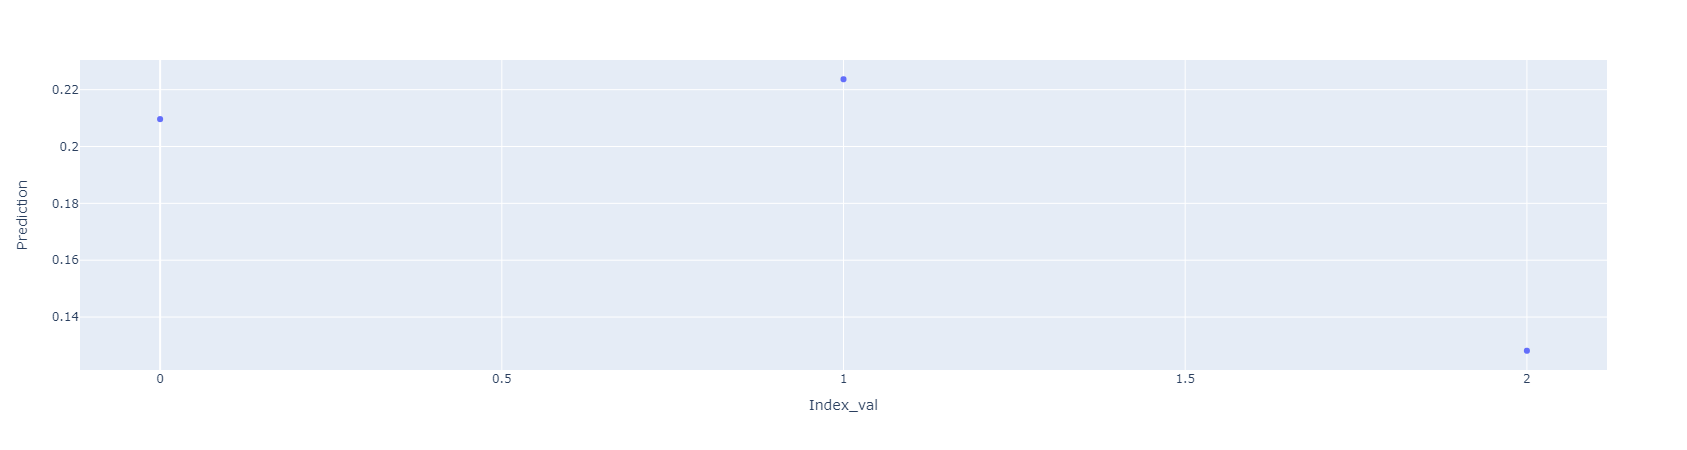

In [32]:
display(df_RNN)
df_RNN_line_chart=pd.DataFrame(columns=["Index_val","Prediction"])
for i,k in enumerate(df_RNN.prediction):
    #print(i,k[0][0])
    row1 = pd.Series([i,k[0][0]] ,index=df_RNN_line_chart.columns )
    df_RNN_line_chart.loc[len(df_RNN_line_chart.index)] = row1
    
display(df_RNN_line_chart)

df_RNN_line_chart_2=df_RNN.merge(df_RNN_line_chart,left_index=True,right_index=True)

display(df_RNN_line_chart_2)
    


import plotly.express as px
fig = px.scatter(df_RNN_line_chart_2, x="Index_val", y="Prediction",hover_data=['p_units','p_epoch','p_batch_size'])
fig.show()



In [ ]:
#****---------------------------------------------------------------------------------------------------------------------------



In [ ]:
for x in df_RNN.prediction:
    print(float(x))
    


In [ ]:
df_ada = pd.DataFrame(getRates('ADA-USD',  '10y',  '1d'))

display((df_ada))


df_ada["s1"]=df_ada["Close"].shift(1)

z=df_ada.iloc[2]

print(z)

In [ ]:
Crypto_Pairs=["BTC-USD","ETH-USD","ADA-USD","ALG-USD","XRP-USD"]



dfx=getRatesTable(*Crypto_Pairs)

display(dfx)

display( dfx.iloc[2:,0:4].values )

z=dfx.iloc[2:,0:4].values

display(z.shape)
display(type(z))

In [ ]:
from datetime import timedelta


dfe0=getRates('ETH-USD',  '10y',  '1d')


display(type(dfe0))


display(dfe0)

date=dfe0.index[0]+ timedelta(days=-1)
s1 = pd.Series([0],index=[date])

dfe1=s1.append(dfe0)

display(dfe1)


In [ ]:
#ANN SAMPLE

'''
import tensorflow as tf
from tensorflow.keras.layers import Dense



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)


ann=tf.keras.Sequential()
ann.add(tf.keras.layers.Dense(units=12,
                              activation="relu"))

ann.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
#ann.compile(loss='mean_squared_error', optimizer='adam' ,metrics=['mse'])

 Fitting the ANN to the Training set
ann.fit(X_train, y_train ,batch_size = 50, epochs = 100)
'''


In [36]:
p_list=[]
for z in range (10,500,10):
    #print(z)
    p_list.append([z,10,150])
    

display(p_list)

[[10, 10, 150],
 [20, 10, 150],
 [30, 10, 150],
 [40, 10, 150],
 [50, 10, 150],
 [60, 10, 150],
 [70, 10, 150],
 [80, 10, 150],
 [90, 10, 150],
 [100, 10, 150],
 [110, 10, 150],
 [120, 10, 150],
 [130, 10, 150],
 [140, 10, 150],
 [150, 10, 150],
 [160, 10, 150],
 [170, 10, 150],
 [180, 10, 150],
 [190, 10, 150],
 [200, 10, 150],
 [210, 10, 150],
 [220, 10, 150],
 [230, 10, 150],
 [240, 10, 150],
 [250, 10, 150],
 [260, 10, 150],
 [270, 10, 150],
 [280, 10, 150],
 [290, 10, 150],
 [300, 10, 150],
 [310, 10, 150],
 [320, 10, 150],
 [330, 10, 150],
 [340, 10, 150],
 [350, 10, 150],
 [360, 10, 150],
 [370, 10, 150],
 [380, 10, 150],
 [390, 10, 150],
 [400, 10, 150],
 [410, 10, 150],
 [420, 10, 150],
 [430, 10, 150],
 [440, 10, 150],
 [450, 10, 150],
 [460, 10, 150],
 [470, 10, 150],
 [480, 10, 150],
 [490, 10, 150]]